In [136]:
# import libraries 
import matplotlib.pyplot as plt
import os, requests
import numpy as np
import pandas as pd
import csv
import seaborn as sb
import matplotlib as pt
import scipy.optimize
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Dataset

In [137]:
# add file location
os.chdir('C:\\Users\\francon\\Downloads\\data')

In [138]:
#Load necessary  files into data frames
coviddf = pd.read_csv("covid_data.csv", error_bad_lines=False, warn_bad_lines=False, encoding='latin-1',delimiter = ",")

In [139]:
coviddf.head(1)

,location,date,new_cases,new_deaths,population,aged_65_older_percent,gdp_per_capita,hospital_beds_per_thousand
0,Afghanistan,2019-12-31,0,0,38928341.0,2.581,1803.987,0.5


### Data Cleaning

In [140]:
# check data types 
coviddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23082 entries, 0 to 23081
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   location                    23082 non-null  object 
 1   date                        23082 non-null  object 
 2   new_cases                   23082 non-null  int64  
 3   new_deaths                  23082 non-null  int64  
 4   population                  23018 non-null  float64
 5   aged_65_older_percent       20643 non-null  float64
 6   gdp_per_capita              20711 non-null  float64
 7   hospital_beds_per_thousand  19144 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 1.4+ MB


In [141]:
coviddf.describe()

,new_cases,new_deaths,population,aged_65_older_percent,gdp_per_capita,hospital_beds_per_thousand
count,23082.000000,23082.000000,2.301800e+04,20643.000000,20711.000000,19144.000000
mean,624.769257,35.629062,1.037003e+08,9.758570,22708.384791,3.204687
std,5517.309068,330.986941,6.716897e+08,6.445662,21187.826121,2.593700
min,-2461.000000,-1918.000000,8.090000e+02,1.144000,661.240000,0.100000
25%,0.000000,0.000000,2.083380e+06,3.853000,6426.674000,1.400000
50%,3.000000,0.000000,9.449321e+06,7.646000,15524.995000,2.600000
75%,55.000000,1.000000,3.346920e+07,15.322000,35220.084000,4.210000
max,133510.000000,10520.000000,7.794799e+09,27.049000,116935.600000,13.800000


We can analyze some values with this table. It seems that there are some observations that could be wrong. 
- There are negative variables for new_cases and new_deaths but if we analyze these variables in the real life they can not be negative
- I will ignore negative values of these variables
   

In [142]:
# ignore negative numbers of new cases and new deaths
coviddf[coviddf.select_dtypes(include=[np.number]).ge(0).all(1)].describe()

,new_cases,new_deaths,population,aged_65_older_percent,gdp_per_capita,hospital_beds_per_thousand
count,18315.000000,18315.000000,1.831500e+04,18315.000000,18315.000000,18315.000000
mean,784.880207,44.881518,1.269424e+08,10.156367,23336.632846,3.126497
std,6183.781361,370.721681,7.510070e+08,6.461980,21236.226370,2.455429
min,0.000000,0.000000,9.792800e+04,1.144000,661.240000,0.100000
25%,0.000000,0.000000,4.105268e+06,4.469000,7485.013000,1.380000
50%,6.000000,0.000000,1.070898e+07,8.153000,16277.671000,2.600000
75%,98.000000,2.000000,4.373376e+07,15.413000,35220.084000,4.210000
max,133510.000000,10520.000000,7.794799e+09,27.049000,116935.600000,13.050000


### Solution

<b>9) Second Dataset, Covid19 cases. 
This dataset contains daily covidl9 cases for all countries in the world. Each row represents a calendar day. The rows also contain some simple information about the countries, like population, percentage of the population over 65, GDP and hospital beds per thousand inhabitants. Please use this dataset to answer the following questions.

When did the difference in the total number of confirmed cases between Italy and Germany become more than 10 000?

In [143]:
# copy specific information we need of Germany and Italy
germanydf=coviddf[coviddf['location']== 'Germany'][["date","new_cases"]]
italydf=coviddf[coviddf['location']== 'Italy'][["date","new_cases"]]

In [144]:
# change the name of new cases per country
germanydf.rename(columns={'new_cases':'new_cases_germany'}, inplace=True)
italydf.rename(columns={'new_cases':'new_cases_italy'}, inplace=True)

In [145]:
# merge the information using date
countrinfodf = pd.merge(germanydf, italydf,on='date')

In [146]:
# calculate the cumulative cases per country
countrinfodf['new_cases_germany_cum'] = countrinfodf['new_cases_germany'].cumsum()
countrinfodf['new_cases_italy_cum'] = countrinfodf['new_cases_italy'].cumsum()

In [147]:
# calculate the difference between variables before
countrinfodf["difference_cases_cum"]= countrinfodf["new_cases_italy_cum"]-countrinfodf["new_cases_germany_cum"]

In [148]:
# get the date when the difference between cases were more than 10K
countrinfodf[countrinfodf['difference_cases_cum']>= 10000].head(1)

,date,new_cases_germany,new_cases_italy,new_cases_germany_cum,new_cases_italy_cum,difference_cases_cum
72,2020-03-12,271,2313,1567,12462,10895


R9. <b>The difference in the total number of confirmed cases between Italy and Germany became more than 10 000 at 2020-03-12

<b>10) Look at the cumulative number of confirmed cases in Italy between 2020-02-28 and 2020-03-20. Fit an exponential function (y = Ae^(Bx)) to this set to express cumulative cases as a function of days passed, by minimizing squared loss. What is the difference between the exponential curve and the total number of real cases on 2020-03-20?

In [149]:
# get the necessary information about cumulative cases and dates
italycasesdf = countrinfodf[(countrinfodf["date"] >= "2020-02-28")&(countrinfodf["date"] <= "2020-03-20")][["date","new_cases_italy_cum"]]

In [150]:
italycasesdf.head()

,date,new_cases_italy_cum
59,2020-02-28,650
60,2020-02-29,888
61,2020-03-01,1128
62,2020-03-02,1689
63,2020-03-03,2036


<b></b>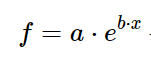

<b> Fit Exponential curve </b><br>
To fit the cumulative cases in function of days passed using exponential formula
to achieve the task, it is necessesary following the next steps:
 - define the independent and dependent variables, in this case x and y would be the total of days and the cumulative cases respectably 
 - implement a function that represents exponential formula
 - apply curvefit function from scipy to fit data, this function uses leastsq 

 
 
 
 

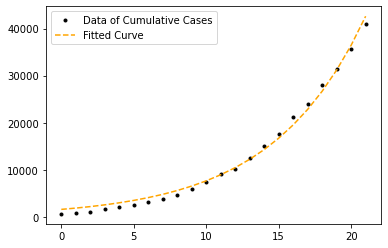

In [151]:
# Implement the fitting
# define the exponential function
def exp_func(x, a, b):
  return a * np.exp(b * x) 
# define variables
y_data = italycasesdf["new_cases_italy_cum"]
x_data = np.arange(0, len(y_data))

# use curvefit 
popt,cov = scipy.optimize.curve_fit(exp_func, x_data, y_data)
a,b = popt

#calculate new values
x_new_value = np.arange(min(x_data), max(x_data)+1)
y_new_value = exp_func(x_new_value, a, b)

plt.figure()
plt.plot(x_data, y_data, '.', label="Data of Cumulative Cases",color="black")
plt.plot(x_new_value, y_new_value, '--', label="Fitted Curve",color="orange")
plt.legend()
plt.show()

In [152]:
# add the fitted data
italycasesdf[['new_cases_cum_fitted']] = y_new_value

In [153]:
italycasesdf['date'] = pd.to_datetime(italycasesdf['date'])

<Figure size 432x288 with 0 Axes>

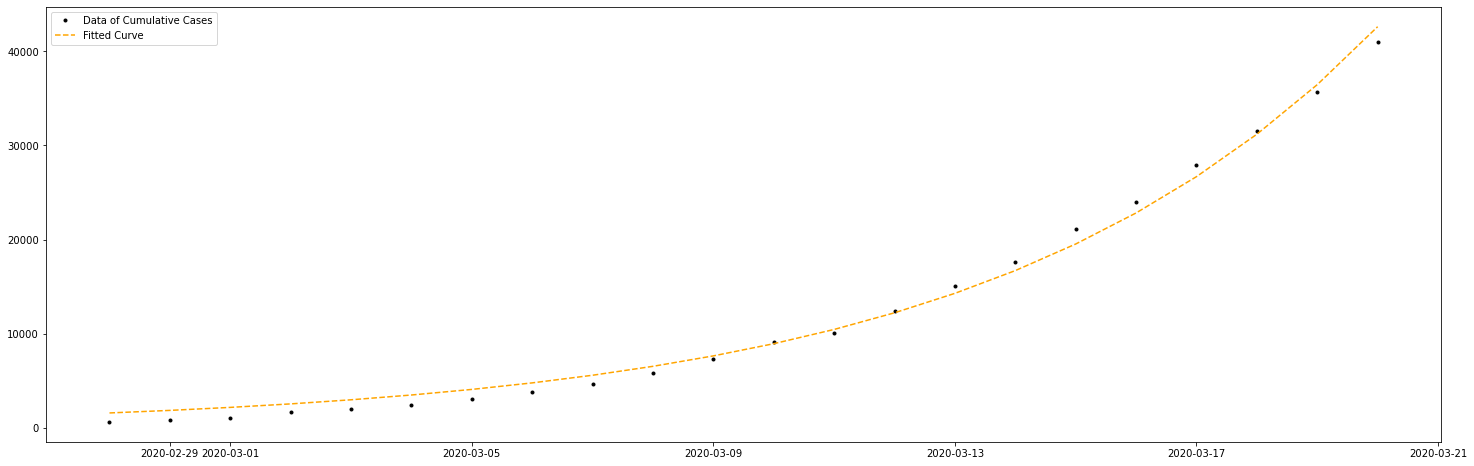

In [154]:
# plot the fitted curve and the real data
plt.figure()
plt.figure(figsize=(25,8))
plt.plot(italycasesdf['date'], italycasesdf['new_cases_italy_cum'], '.', label="Data of Cumulative Cases",color="black")
plt.plot(italycasesdf['date'], italycasesdf['new_cases_cum_fitted'], '--', label="Fitted Curve",color="orange")
plt.legend()
plt.show()

In [155]:
# calculate the difference between fitted data and real data
italycasesdf[italycasesdf["date"] == "2020-03-20"]

,date,new_cases_italy_cum,new_cases_cum_fitted
80,2020-03-20,41035,42608.506785


In [156]:
# calculate the difference at that day
diff =italycasesdf.loc[italycasesdf.date=="2020-03-20", 'new_cases_cum_fitted'].values[0] - italycasesdf.loc[italycasesdf.date=="2020-03-20", 'new_cases_italy_cum'].values[0]
print("The difference between the exponential curve and the total number of real cases on 2020-03-20 is",round(diff,2))

The difference between the exponential curve and the total number of real cases on 2020-03-20 is 1573.51


<b>11) Which country has the 3rd highest death rate? Death rate: total number of death per million inhabitants



In [157]:
# get the information per country to calculate the death rate
deathratedf=coviddf.groupby(['location'],as_index=False).agg({'new_deaths': np.sum, 'population': np.max})

In [158]:
# get the information 
deathratedf["death_rate"]= (deathratedf["new_deaths"]/deathratedf["population"])*1000000

In [159]:
deathratedf.nlargest(3,['death_rate'])

,location,new_deaths,population,death_rate
163,San Marino,42,33938.0,1237.550828
18,Belgium,9619,11589616.0,829.967102
3,Andorra,51,77265.0,660.066007


R11 <b>It shows Andorra has the 3rd highest death rate

<b>12) What is the F1 score of the following statement: Countries, where more than 20% of the population is over 65 years old, have death rates over 50 per million inhabitants. Ignore countries, where any of the necessary information is missing!

In [160]:
countdeathrate=coviddf[coviddf["aged_65_older_percent"]>20]

In [161]:
# get the information of percentage with people over 65 years old per country 
countdeathrate=countdeathrate.groupby(['location'],as_index=False).agg({'aged_65_older_percent': np.max})

In [162]:
countdeathrate

,location,aged_65_older_percent
0,Bulgaria,20.801
1,Finland,21.228
2,Germany,21.453
3,Greece,20.396
4,Italy,23.021
5,Japan,27.049
6,Portugal,21.502


In [163]:
countdeathrate = pd.merge(countdeathrate, deathratedf,on='location')
countdeathrate

,location,aged_65_older_percent,new_deaths,population,death_rate
0,Bulgaria,20.801,167,6948445.0,24.034154
1,Finland,21.228,324,5540718.0,58.476176
2,Germany,21.453,8729,83783945.0,104.184638
3,Greece,20.396,183,10423056.0,17.557231
4,Italy,23.021,34043,60461828.0,563.049467
5,Japan,27.049,919,126476458.0,7.266174
6,Portugal,21.502,1492,10196707.0,146.321749


<b>13) What is the probability that a country has GDP over $10 000, if we know that they have at least 5 hospital beds per 1000 inhabitants.

In [89]:
# filter the countries where they have at least 5 hospital per 1000 inhb
gdp=coviddf[coviddf["hospital_beds_per_thousand"]>=5]

In [92]:
# get the information per country
gdp=gdp.groupby(['location'],as_index=False).agg({'gdp_per_capita': np.max, 'hospital_beds_per_thousand': np.max})

In [100]:
# delete nan values
gdp=gdp.dropna()

<AxesSubplot:xlabel='gdp_per_capita', ylabel='Density'>

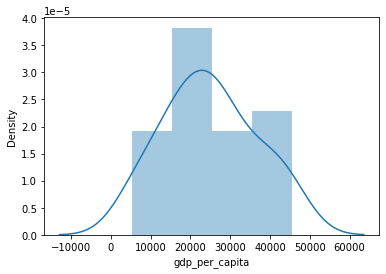

In [103]:
# this graphic shows the distribution of data
sb.distplot(gdp["gdp_per_capita"])

In [105]:
# get the mean and std
gdp["gdp_per_capita"].describe()

count       26.000000
mean     24875.705538
std      11583.134812
min       5189.972000
25%      17025.542750
50%      24410.771000
75%      31993.217500
max      45436.686000
Name: gdp_per_capita, dtype: float64

In [110]:
24875.70-(11583.13*2)

1709.4400000000023

<b>we need to calculate P(X>10000)

In [120]:
x = 10000

In [121]:
# get z score value
z_value = (x-gdp["gdp_per_capita"].mean())/gdp["gdp_per_capita"].std()

In [122]:
# obtain the probability of z score
scipy.stats.norm.cdf(z_value)

0.09952627149745163

In [128]:
# get the probability of p(x>100000)
print("The probability that a country has GDP over $10 000  is ",round((1-scipy.stats.norm.cdf(z_value))*100,3))

The probability that a country has GDP over $10 000  is  90.047


R13.<b>The probability that a country has GDP over $10 000  is  90.047